In [1]:
## Standard Imports ##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import numpy as np
import scipy as sp
import scipy.io as writer

import time as timeit
import datetime
import sys,os

## Torch Functions ##
import os
import torch
import torch.distributions.constraints as constraints
torch.set_default_dtype(torch.float64) # Set default type to float64 (instead of float32)

## Update External Codes ##
import importlib

## Import Handmade Functions ##
sys.path.append(os.path.join(os.path.abspath(''), '../00-GeneralFunctions'))
import varFam
import stochMod_annealing as stochMod

## Variational Inference Example
In this file, I develop an automatic differention variational inference (ADVI) solution to the identification of a single-degree-of-freedom oscillator (SDOF), in which the nonlinear switch state is turned ON, essentially developing a Bouc-Wen SDOF system. The nonlinear stiffness contribution is turned on for this part of the example, as part of the switch state for this system. 

ADVI, which falls into the optimization class of Bayesian filtering approximations, incorporates a small set of hyperparameters used to adjust the properties of the stochastic gradient descent algorithm that optimizes the approximate posterior against the Kullback-Leibler (KL) divergence. For this example, these hyperparameters were selected to develop a reasonable and consistent approximation of the posterior with relatively low variance in the optimization history (evidence lower bound values at each optimization step). These variables include: 
 
1. $N_{epoch}$, stated as ```numEpoch``` in the code. This variable represents the number of epochs used in the optimization process. At the beginning of each epoch, the gradients are cleared and new starting values are assigned to the optimization parameters and the learning rates. 
2. $N_{iter}$, stated as ```epochIter``` in the code. This variable represents the number of optimization iterations used in each epoch. 
3. $l_r$, stated as ```lr``` in the code. This variable represents the step size amplifier for the optimization step scheduler. The meaning of this can be different depending on which stochastic optimization algorithm you select. For the purposes of this example, we will be using the Adam algorithm. 
4. $N_{MC}$, stated as ```MCSamp``` in the code. This variable represents the number of MC samples on the inferred states/parameters that will be used as part of reducing to reduce the variance of the stochastic gradient descent algorithm. 

In addition to these variables, the algorithm used herein also incorporates the option to develop the approximate marginal posteriors through KL-annealing <sup>1</sup>. This process more heavily weights the fit of the model to the data at the beginning of the optimization process. As the optimization progresses, the contribution of the prior to the loss function is more heavily weighted, until the weighting on the prior and on the likelihood is equal at the final optimization iteration. Though the annealing schedule can be generated in many ways, here we select a linear schedule. 

This example runs 50 inference trials using varied prior information on the parameters, simulating different assertions an experimentalist might make in a practical identification scenario. Outputs from this model include:
1. The mean and standard deviation of the log(parameters) over the optimization history.
2. The mean and standard deviation of the states at the final step optimization
3. The mean and mode of the parameters over the optimization history. 
4. The computational model response built from the inferred parameters with respect to the input signal used for inference.
5. The runtime for each inference trial. 

The user should note that this algorithm, unlike the others demonstrated in this illustrative example, operates in a 'batch' mode, evaluating all of the data at once, rather than a 'filter' mode, which evaluates data points successively. Though research is ongoing in the development of practical variational filtering approaches, and therefore there is no "standard" method that can be extrapolated on for this example, the authors still felt that it was important to give a comparison between the base variational inference approach and the other algorithms. 

The VI implementation expressed herein is drawn from the python library pyTorch<sup>2</sup> and relies heavily on the work of Kucukelbir et al.<sup>3</sup>. 

__Developed by__: Alana Lund (Purdue University) \
__Last Updated__: 25 Oct. 2021 \
__License__: AGPL-3.0

### References
<sup>1</sup> C.-W. Huang, S. Tan, A. Lacoste, A. Courville. Improving the Explorability in Variational Inference with Annealed Variational Objectives. _arXiv preprint arXiv:1809.01818_ (2018).

<sup>2</sup> A. Paszke, S. Gross, F. Massa, A. Lerer, J. Bradbury, G. Chanan, T. Killeen, Z. Lin, N. Gimelshein, L. Antiga, A. Desmaison, A. Köpf, E. Yang, Z. DeVito, M. Raison, A. Tejani, S. Chilamkurthy, B. Steiner, L. Fang, J. Bai, S. Chintala, [PyTorch: an imperative style, high-performance deep learning library](https://pytorch.org/) in: Adv. Neural Inf. Process. Syst., 2019: pp. 8024–8035. http://arxiv.org/abs/1912.01703.


<sup>3</sup> A. Kucukelbir, D. Tran, R. Ranganath, A. Gelman, D. Blei. Automatic Differentiation Variational Inference. _Journal of Machine Learning Research_ (2017). 

## Load Experimental Data

In [23]:
## Assert File Names
inFile = '../04-Data/Bouc-Wen/inferenceInput'
outFile = '../04-Data/Bouc-Wen/outputVI'

infData = np.load(inFile + '.npz')

dt = infData['dt']                 # time step [sec]
time = infData['time']             # time history [sec]
inpAcc = infData['inpAcc']         # observations on input acceleration [m/sec^2]
states = infData['statesPNoise']   # states (for post-inference validation) [m,m/sec,m]
respAcc = infData['accPMNoise']    # observations on response acceleration [m/sec^2]
Q = infData['Qfactor']             # process noise contributions, independent std. dev. per state [m,m/sec,m]
R = infData['Rfactor']             # measurement noise contribution [m/sec^2]
m = infData['m']                   # mass [kg]
ics = infData['ics']               # true initial conditions of the system [m, m/sec, m]
par = infData['par']               # true parameters of the system [xi (-), wn (rad/sec), beta [1/m^2], n [-], gamma [1/m^2]] 

### Lay Out Problem Dimensionality ###
numInf = 8                     # Number of inferred variables [-]
nState = states.shape[0]     # Number of states [-]
nPar = numInf - nState         # Number of parameters [-]
samps = len(time)            # Number of system measurements [-]

### Set Aside Pre-Selected Seeds for Each Inference Trial ###
noiseSeeds = np.array([[362447,221795,415188,851692,429994,875432,34204,930263,612276,803118,
    988942,148487,52253,217254,186481,823575,894512,936909,94514,34263
    ,420,365133,366385,168921,262852,562762,290278,104994,687545,123494
    ,71194,236227,654985,458480,60785,5978,164453,795134,733948,994617
    ,251981,497532,145974,637560,367309,503274,278070,738365,146207,919550]
    ,[375559,596157,405683,662582,615421,873481,815801,692548,678472,977676
    ,576723,541565,814346,994860,692387,737166,904958,484792,697589,915172
    ,814859,791522,768595,592237,923599,500042,703901,902362,827779,171795
    ,1793,66521,518574,520292,898293,666632,654687,426340,44827,648037
    ,828481,247297,737387,884103,638953,415614,484558,198179,454962,849656]])

## System Model

In [3]:
### MODELLING FUNCTIONS FOR DYNAMICAL SYSTEM ###
def fx(x, dt, exc=None):
    """
    State transition model for a SDOF oscillator with a Bouc-Wen switch 
    state, given that alpha = 0, and therefore the Bouc-Wen component is 
    switched off.
      
    x = 1x8 vector of states (disp [m], vel [m/sec], Bouc-Wen disp [m]) 
                and parameters to be inferred (log(xi),log(wn), log(beta), 
                log(n), log(gamma)). 
    dt = sampling rate [sec]
    exc = input excitation at current time step [m/sec^2]
    """
    if exc is None:
        exc = np.zeros(x[1].shape)
      
    par = np.exp(x[3:]) 
            
    x1dot = x[0] + dt*x[1]
    x2dot = x[1] + dt*(-exc - (2*par[0]*par[1])*x[1] - np.square(par[1])*x[2])
    x3dot = x[2] + dt*(x[1] - par[2]*np.absolute(x[1])*
                np.power(np.absolute(x[2]), par[3]-1)*x[2] 
                - par[4]*x[1]*np.power(np.absolute(x[2]), par[3]))

    return np.concatenate((np.stack((x1dot, x2dot, x3dot), axis=0)
                           , x[3:]), axis=0)

## Run ADVI
The ADVI implementation demonstrated herein is an in-house code based on the work of Kucukelbir et al. (2017). The process below sets up the optimization using the functions and classes built in the files stochMod_annealing.py, which sets up a class to describe the priors and a class to describe the stochastic dynamical system model, and varFam.py, which sets up a class to describe the variational family. Detailed descriptions of these classes and their functionalities are given in the respective .py files. 

In [10]:
## Define Constants ##
nConst = 4
# Measurement Noise #
vConst = stochMod.Deterministic('constants', 0, R, name = 'Acceleration Noise')
# Process Noise #
w1Const = stochMod.Deterministic('constants', 1, Q[0], name = 'Process Noise on X1')
w2Const = stochMod.Deterministic('constants', 2, Q[1], name = 'Process Noise on X2')
w3Const = stochMod.Deterministic('constants', 3, Q[2], name = 'Process Noise on X3')

## Set Prior on the Initial Conditions of the States ##
x1Inf = stochMod.Normal('disp', 0, 0, 0.05, name = 'X1(0)')
x2Inf = stochMod.Normal('vel', 0, 0, 0.05, name = 'X2(0)')
x3Inf = stochMod.Normal('rdisp', 0, 0, 0.05, name = 'X3(0)')

## Load Prior Distribution on the Parameters ##
parPriors = np.loadtxt('../04-Data/parameter_priors.txt')

## Define Variational Inference Parameters ##   
numEpoch = 2                           # Number of Epochs
epochIter = np.array([600000, 1400000])  # Iterations per Epoch
storeInt = 100                         # Interval at which to store inference history
optIter = int(np.sum(epochIter)/storeInt) + 1 # Total number of optimization steps
nStore = int(epochIter[0]/storeInt)    # Number of values to store per epoch
reportInt = epochIter[0]/10            # Interval at which to report inference history
annealSelect = True                    # Option to use KL Annealing 

## Set Parameters and Data for Stochastic Gradient Descent ##
MCSamp = 6                    # Number of MC Samples for SGD
data = torch.tensor(respAcc)  # observed data for optimization
vibr = torch.tensor(inpAcc)   # input acceleration
lr = {'disp': np.array([0.0001,0.00005]),
       'vel': np.array([0.0001,0.00005]),
       'rdisp': np.array([0.0001,0.00005]),
       'par': np.array([0.0001,0.00005])}  # Learning Rate for Adam SGD


### Generate Storage Over Inferred States/Parameters ###
muHist = np.zeros((parPriors.shape[0],nPar, optIter))
    # mu value of the inferred parameters for each inference trial
    # over the optimization history. This is what VI directly
    # outputs
stdHist = np.zeros((parPriors.shape[0],nPar, optIter))
    # standard deviation of the inferred parameters for each 
    # inference trial over the optimization history. This is 
    # what VI directly outputs
meanHist = np.zeros((parPriors.shape[0],nPar, optIter))
    # mean of the underlying parameters for each inference trial over
    # the observation period. This measure takes the mean of the 
    # lognormal posteriors of the parameters.
modeHist = np.zeros((parPriors.shape[0],nPar, optIter))
    # mode of the underlying parameters for each inference trial over
    # the observation period. This measure takes the mode of the 
    # lognormal posteriors of the parameters.
muStates = np.zeros((parPriors.shape[0],nState, samps))
    # mu value of the final inferred states for each inference 
    # trial at the end of the optimization history. This is 
    # what VI directly outputs
stdStates = np.zeros((parPriors.shape[0],nState, samps))
    # standard deviation of the final inferred parameters for each 
    # inference trial at the end of the optimization history.  
    # This is what VI directly outputs
modStates = np.zeros((parPriors.shape[0],numInf, samps))
    # Response history of the inferred system given the input
    # excitation. Essentially, we're remodeling the behavior of 
    # the system given our selections on point estimates of the 
    # parameters from the posterior. 
runTime = np.zeros((parPriors.shape[0]))
    # Computational time for each inference trial. 

TypeError: 'LogNormal' object cannot be interpreted as an integer

In [ ]:
## For Each Inference Trial... ##
for j in range(parPriors.shape[0]):
    ## Ensure Repeatability ##
    torchSeed = noiseSeeds[0,j]
    torch.manual_seed(torchSeed)
    
    npSeed = noiseSeeds[1,j]
    np.random.seed(npSeed)
    
    # Set Prior on Parameters #
    mu0 = parPriors[j,::2]
    sig0 = parPriors[j,1::2]
    xiInf = stochMod.LogNormal('par', 0, mu0[0], sig0[0], name='Xi')
    wnInf = stochMod.LogNormal('par', 1, mu0[1], sig0[1], name='Wn')
    BInf = stochMod.LogNormal('par', 2, mu0[2], sig0[2], name='Beta')
    nInf = stochMod.LogNormal('par', 3, mu0[3], sig0[3], name='N')
    GInf = stochMod.LogNormal('par', 4, mu0[4], sig0[4], name='Gamma')
    
    ## Define Stochastic Time Series Model ##
    allPriors = {'x1': x1Inf, 'x2':x2Inf, 'x3':x3Inf,
             'xi':xiInf, 'wn': wnInf, 
             'beta':BInf, 'n': nInf, 'gamma':GInf,
             'w1': w1Const, 'w2': w2Const, 'w3': w3Const,
             'v':vConst}
    sdof = stochMod.BWSDOF_Euler(dt, allPriors)
    
    ## Define Variational Family ##
    guide = {'disp': varFam.NormalTri(size=samps, storage = nStore),
            'vel': varFam.NormalTri(size=samps, storage = nStore),
             'rdisp': varFam.NormalTri(size=samps, storage = nStore),
            'par': varFam.NormalDiag(size = nPar, storage = nStore, 
                                m = torch.tensor([xiInf.transMean, wnInf.transMean, 
                                                  BInf.transMean, nInf.transMean, GInf.transMean]), 
                                log_s = torch.tensor([np.log(np.sqrt(xiInf.transVar)),
                                                      np.log(np.sqrt(wnInf.transVar)),
                                                     np.log(np.sqrt(BInf.transVar)),
                                                     np.log(np.sqrt(nInf.transVar)),
                                                     np.log(np.sqrt(GInf.transVar))])),
            'constants': varFam.Deterministic(size = nConst, storage = nStore, 
                                             m=torch.tensor(np.array([vConst.par[0], 
                                             w1Const.par[0], w2Const.par[0], w3Const.par[0]])))}
            # This dictionary developes a parameterized distribution over the parameters
            # to be inferred which approximates the true posterior.
            
    
    ## Run ADVI ##
    t0 = timeit.time()
    (elboHist, infMeans, infLs) = stochMod.inferTimeSeries(sdof,guide,data,vibr, 
                        lr, MC=MCSamp,nEpoch=numEpoch,epochIter=epochIter,
                        sInt=storeInt,rInt=reportInt, anneal = annealSelect)

    tf = timeit.time()
    runTime[j] = ((tf-t0)/60)
    
    ## Store Inference Results on the States ##
    muStates[j,0,:] = infMeans['disp'][-1]
    stdStates[j,0,:] = infLs['disp'][-1]
    muStates[j,1,:] = infMeans['vel'][-1]
    stdStates[j,1,:] = infLs['vel'][-1]
    muStates[j,2,:] = infMeans['rdisp'][-1]
    stdStates[j,2,:] = infLs['rdisp'][-1]  

    ## Store Inference Results on the Parameters ##
    parMeans = infMeans['par']
    parStds = infLs['par']
    muHist[j] = np.transpose(parMeans)
    stdHist[j] = np.transpose(parStds)
    meanHist[j] = np.transpose(np.exp(parMeans + np.square(parStds)/2.))
    modeHist[j] = np.transpose(np.exp(parMeans - np.square(parStds)))

    ### Rerun Model with Identified Parameters ###
    modStates[j,:,0] = np.concatenate((np.zeros((nState,)), np.log(modeHist[j,:,-1])))
    for k in range(1,samps):
        modStates[j,:,k] = fx(modStates[j,:,k-1], dt, exc=inpAcc[k-1]) 
   
    ## Print Results Summary ##
    print('\nIteration %d' %(j))
    print('\tComputation Time = %d minutes and %d seconds' %(np.floor((tf-t0)/60), 
                                                        np.floor((tf-t0) - 60*np.floor((tf-t0)/60))))
    print('\tMode of Final Parameter Distributions: \n\t\txi = %.4f,\n\t\twn = %.4f,\n\t\tbeta = %.4f,\n\t\tn = %.4f,\n\t\tgamma = %.4f\n'
          %(modeHist[j,0,-1],modeHist[j,1,-1],modeHist[j,2,-1],modeHist[j,3,-1],modeHist[j,4,-1]))

np.savez(outFile, muHist = muHist,stdHist=stdHist, 
         meanHist=meanHist, modeHist=modeHist, modStates=modStates, 
         muStates = muStates, stdStates = stdStates, runTime = runTime)

## Visualize Inference Output
As you may have noticed, the outputs for the variational inference case are structured slightly differently than the outputs for the remainder of the cases. That is because the variational inference case given herein is run in batch mode, whereas the remainder of the example algorithms run in a filtering mode. Because of this, the generalized plotting code, '05-Plot_Results', will not be able to handle the results from the VI case automatically. Instead, I've plotted them here.

### Load Inference Data
This becomes an optional start point in the code. If the data for the UKF has already been generated, it can simply be loaded in for the predictive analysis instead of rerunning the previous block of code. 

In [11]:
outData = np.load(outFile + '.npz')

muHist = outData['muHist']         # optimization history of untransformed par means
stdHist = outData['stdHist']       # optimization history of par standard deviations
meanHist = outData['meanHist']     # optimization history of transformed par means
modeHist = outData['modeHist']     # optimization history of transformed par modes
muStates = outData['muStates']       # final optimized value on the untransformed state means
stdStates = outData['stdStates']     # final optimized value on the untransformed state standard deviations
modStates = outData['modStates']     # states that have been remodeled based on the final modes of the parameters

### Plot Comprehensive Results
This set of figures is intended to give an overview of the results for all inference trials. 

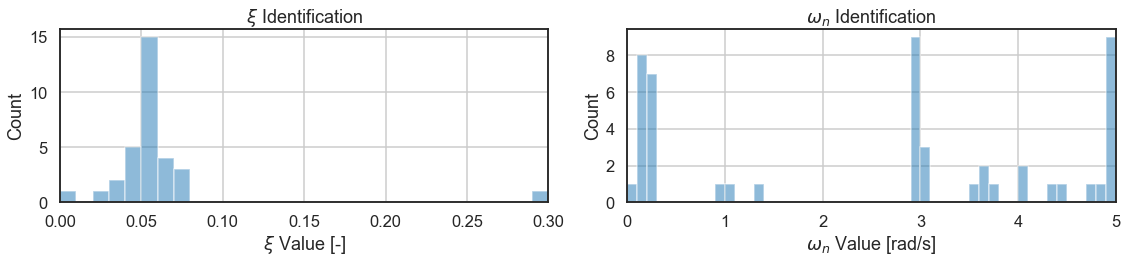

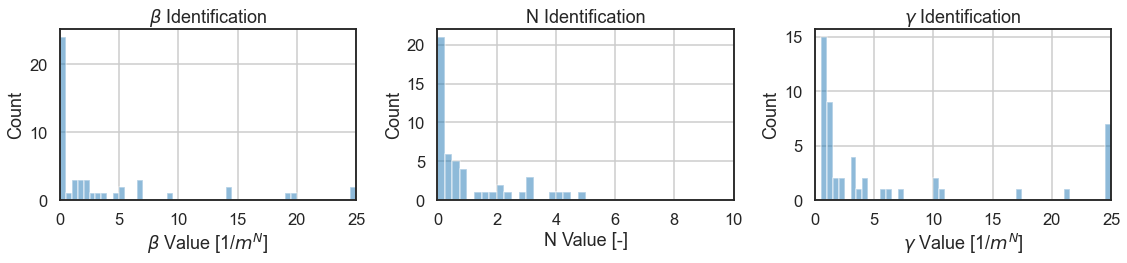

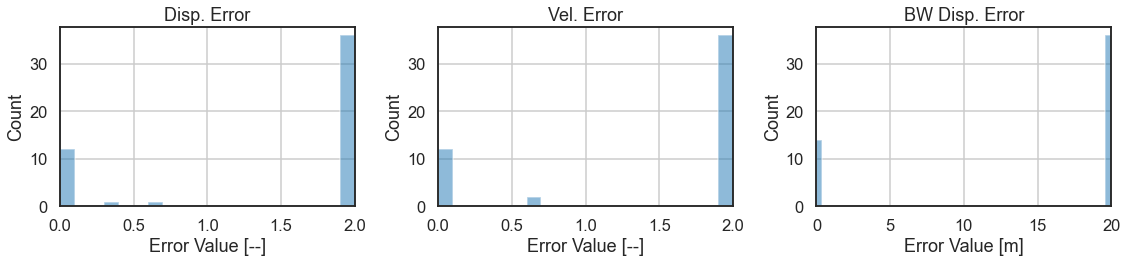

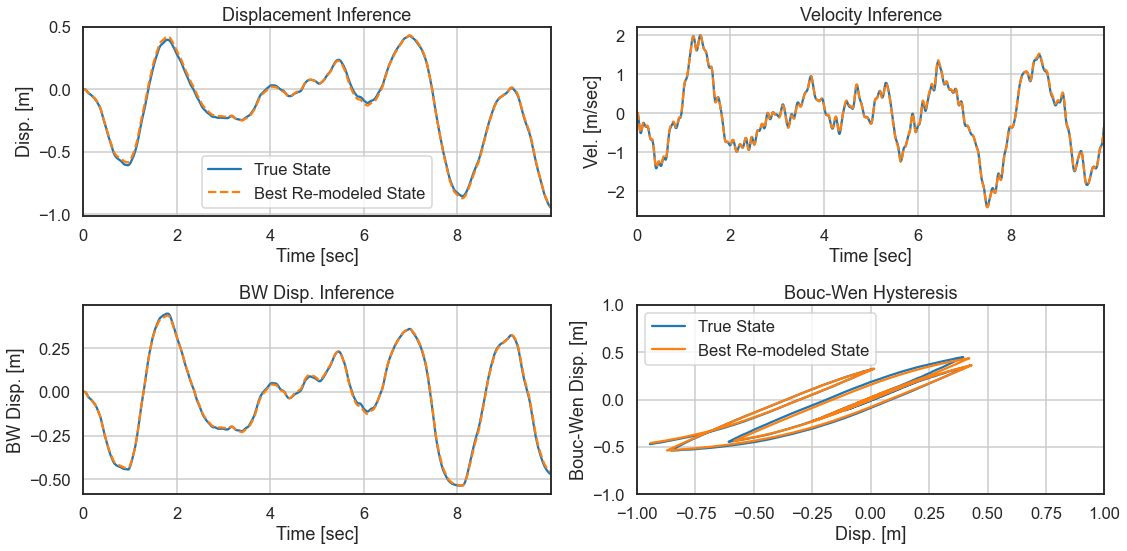

In [15]:
## Linear Parameters ##
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].hist(modeHist[:,0,-1], bins = np.concatenate((np.arange(0,0.3, 0.01), np.array([1]))), label = r"\xi", alpha = 0.5)
ax[0].set_title(r'$\xi$ Identification')
ax[0].set_ylabel('Count')
ax[0].set_xlabel(r'$\xi$ Value [-]')
ax[0].set_xlim((0,0.3))
ax[0].grid(1)
#ax[0].legend()

ax[1].hist(modeHist[:,1,-1], bins = np.concatenate((np.arange(0,5, 0.1), np.array([100]))), label = r'$\omega_n$', alpha = 0.5)
ax[1].set_title(r'$\omega_n$ Identification')
ax[1].set_ylabel('Count')
ax[1].set_xlabel(r'$\omega_n$ Value [rad/s]')
ax[1].set_xlim((0,5))
ax[1].grid(1)

plt.tight_layout()

## Nonlinear Parameters ##
fig, ax = plt.subplots(1,3,figsize = (16,4))
ax[0].hist(modeHist[:,2,-1], bins = np.concatenate((np.arange(0,25, 0.5), np.array([1000]))), label = r'$\beta$', alpha = 0.5)
ax[0].set_title(r'$\beta$ Identification')
ax[0].set_ylabel('Count')
ax[0].set_xlabel(r'$\beta$ Value [1/$m^N$]')
ax[0].set_xlim((0,25))
ax[0].grid(1)
#ax[0].legend()

ax[1].hist(modeHist[:,3,-1], bins = np.concatenate((np.arange(0,10, 0.25), np.array([30]))), label = "N", alpha = 0.5)
ax[1].set_title('N Identification')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('N Value [-]')
ax[1].set_xlim((0,10))
ax[1].grid(1)

ax[2].hist(modeHist[:,4,-1], bins = np.concatenate((np.arange(0,25, 0.5), np.array([1000]))), label = r'$\gamma$', alpha = 0.5)
ax[2].set_title(r'$\gamma$ Identification')
ax[2].set_ylabel('Count')
ax[2].set_xlabel(r'$\gamma$ Value [1/$m^N$]')
ax[2].set_xlim((0,25))
ax[2].grid(1)

plt.tight_layout()   


## State Error ##
RMSDisp = np.sqrt(np.mean(np.square(states[0] - modStates[:,0,:]), axis=1))
findNans = np.isnan(RMSDisp)
RMSDisp[findNans] = 5
RMSVel = np.sqrt(np.mean(np.square(states[1] - modStates[:,1,:]), axis=1))
findNans = np.isnan(RMSVel)
RMSVel[findNans] = 5
RMSRDisp = np.sqrt(np.mean(np.square(states[2] - modStates[:,2,:]), axis=1))
findNans = np.isnan(RMSRDisp)
RMSRDisp[findNans] = 20

fig, ax = plt.subplots(1,3,figsize = (16,4))
ax[0].hist(RMSDisp, bins = np.concatenate((np.arange(0,2, 0.1), np.array([20]))), label = r'Disp.', alpha = 0.5)
ax[0].set_title(r'Disp. Error')
ax[0].set_ylabel('Count')
ax[0].set_xlabel(r'Error Value [--]')
ax[0].set_xlim((0,2))
ax[0].grid(1)
#ax[0].legend()

ax[1].hist(RMSVel, bins = np.concatenate((np.arange(0,2, 0.1), np.array([20]))), label = "Vel.", alpha = 0.5)
ax[1].set_title('Vel. Error')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Error Value [--]')
ax[1].set_xlim((0,2))
ax[1].grid(1)

ax[2].hist(RMSRDisp, bins = np.concatenate((np.arange(0,20, 0.4), np.array([30]))), label = r'BW Disp.', alpha = 0.5)
ax[2].set_title('BW Disp. Error')
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Error Value [m]')
ax[2].set_xlim((0,20))
ax[2].grid(1)

plt.tight_layout()  

## State Error ##
index = np.argmin(RMSDisp)

figure, ax=plt.subplots(2,2,figsize=(16,8)) 
ax[0,0].plot(time, states[0], '-', label='True State')
ax[0,0].plot(time, modStates[index, 0,:], '--', label='Best Re-modeled State')
ax[0,0].set_xlabel('Time [sec]')
ax[0,0].set_ylabel('Disp. [m]')
ax[0,0].set_title('Displacement Inference')
ax[0,0].set_xlim((0, time[-1]))
ax[0,0].grid(1)
ax[0,0].legend()

ax[0,1].plot(time, states[1], '-', label='True State')
ax[0,1].plot(time, modStates[index, 1,:], '--', label='Best Re-modeled State')
ax[0,1].set_xlabel('Time [sec]')
ax[0,1].set_ylabel('Vel. [m/sec]')
ax[0,1].set_title('Velocity Inference')
ax[0,1].set_xlim((0, time[-1]))
ax[0,1].grid(1)

ax[1,0].plot(time, states[2], '-', label='True State')
ax[1,0].plot(time, modStates[index, 2,:], '--', label='Best Re-modeled State')
ax[1,0].set_xlabel('Time [sec]')
ax[1,0].set_ylabel('BW Disp. [m]')
ax[1,0].set_title('BW Disp. Inference')
ax[1,0].set_xlim((0, time[-1]))
ax[1,0].grid(1)

ax[1,1].plot(states[0,:],states[2,:], label="True State")
ax[1,1].plot(modStates[index,0,:],modStates[index,2,:], label="Best Re-modeled State")
ax[1,1].set_xlabel('Disp. [m]')
ax[1,1].set_ylabel('Bouc-Wen Disp. [m]')
ax[1,1].set_title('Bouc-Wen Hysteresis')
ax[1,1].set_xlim((-1,1))
ax[1,1].set_ylim((-1,1))
ax[1,1].grid(1)
ax[1,1].legend()

plt.tight_layout()  

### Plot Results for One Case
This set of figures singles out a specific inference case and examines the results in more detail. 

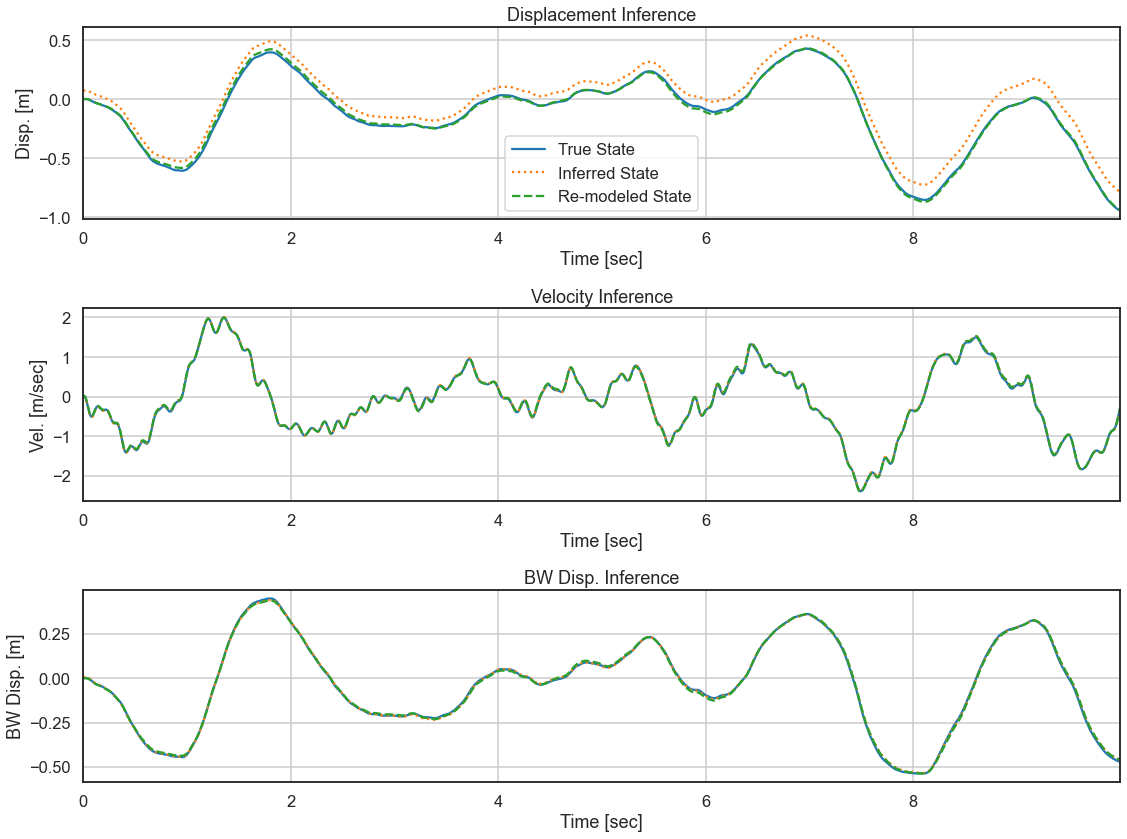

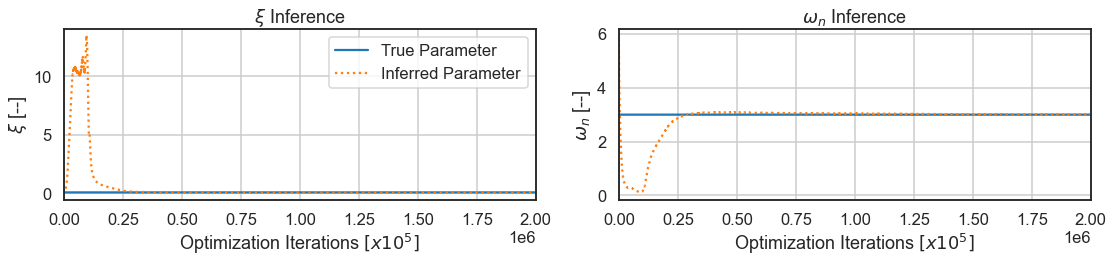

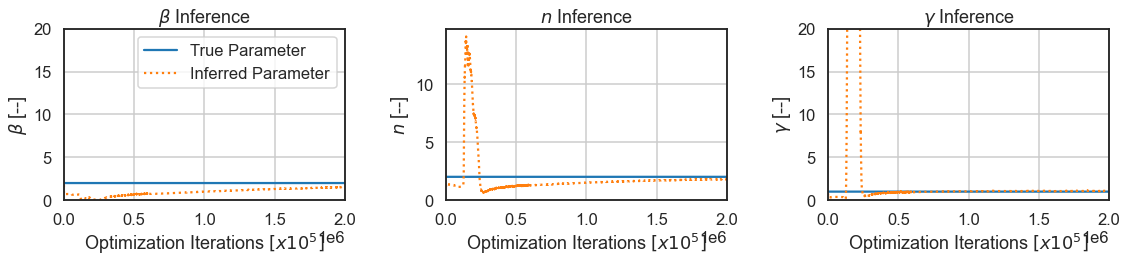

In [18]:
### Plot Results ###
caseSelect = index

## States ##
figure, ax=plt.subplots(3,1,figsize=(16,12)) 
ax[0].plot(time, states[0], '-', label='True State')
ax[0].plot(time, muStates[caseSelect, 0], ':', label='Inferred State')
ax[0].plot(time, modStates[caseSelect, 0], '--', label='Re-modeled State')
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Disp. [m]')
ax[0].set_title('Displacement Inference')
ax[0].set_xlim((0, time[-1]))
ax[0].grid(1)
ax[0].legend()

ax[1].plot(time, states[1], '-', label='True State')
ax[1].plot(time, muStates[caseSelect, 1], ':', label='Inferred State')
ax[1].plot(time, modStates[caseSelect, 1], '--', label='Re-modeled State')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Vel. [m/sec]')
ax[1].set_title('Velocity Inference')
ax[1].set_xlim((0, time[-1]))
ax[1].grid(1)

ax[2].plot(time, states[2], '-', label='True State')
ax[2].plot(time, muStates[caseSelect, 2], ':', label='Inferred State')
ax[2].plot(time, modStates[caseSelect, 2], '--', label='Re-modeled State')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylabel('BW Disp. [m]')
ax[2].set_title('BW Disp. Inference')
ax[2].set_xlim((0, time[-1]))
ax[2].grid(1)

plt.tight_layout()

## Parameters ##
optRange = np.arange(0,np.sum(epochIter)+1,storeInt)
figure, ax=plt.subplots(1,2,figsize=(16,4)) 
ax[0].plot(optRange, par[0]*np.ones(len(optRange)), '-', label='True Parameter')
ax[0].plot(optRange, modeHist[caseSelect, 0], ':', label='Inferred Parameter')
ax[0].set_xlabel(r'Optimization Iterations $[x10^5]$')
ax[0].set_ylabel(r'$\xi$ [--]')
ax[0].set_title(r'$\xi$ Inference')
ax[0].set_xlim((0, optRange[-1]))
ax[0].grid(1)
ax[0].legend()     

ax[1].plot(optRange, par[1]*np.ones(len(optRange)), '-', label='True Parameter')
ax[1].plot(optRange, modeHist[caseSelect, 1], ':', label='Inferred Parameter')
ax[1].set_xlabel(r'Optimization Iterations $[x10^5]$')
ax[1].set_ylabel(r'$\omega_n$ [--]')
ax[1].set_title(r'$\omega_n$ Inference')
ax[1].set_xlim((0, optRange[-1]))
ax[1].grid(1)

plt.tight_layout()

figure, ax=plt.subplots(1,3,figsize=(16,4)) 
ax[0].plot(optRange, 2*np.ones(len(optRange)), '-', label='True Parameter')
ax[0].plot(optRange, modeHist[caseSelect, 2], ':', label='Inferred Parameter')
ax[0].set_xlabel(r'Optimization Iterations $[x10^5]$')
ax[0].set_ylabel(r'$\beta$ [--]')
ax[0].set_title(r'$\beta$ Inference')
ax[0].set_xlim((0, optRange[-1]))
ax[0].set_ylim((0, 20))
ax[0].grid(1)
ax[0].legend() 

ax[1].plot(optRange, 2*np.ones(len(optRange)), '-', label='True Parameter')
ax[1].plot(optRange, modeHist[caseSelect, 3], ':', label='Inferred Parameter')
ax[1].set_xlabel(r'Optimization Iterations $[x10^5]$')
ax[1].set_ylabel(r'$n$ [--]')
ax[1].set_title(r'$n$ Inference')
ax[1].set_xlim((0, optRange[-1]))
ax[1].grid(1)

ax[2].plot(optRange, 1*np.ones(len(optRange)), '-', label='True Parameter')
ax[2].plot(optRange, modeHist[caseSelect, 4], ':', label='Inferred Parameter')
ax[2].set_xlabel(r'Optimization Iterations $[x10^5]$')
ax[2].set_ylabel(r'$\gamma$ [--]')
ax[2].set_title(r'$\gamma$ Inference')
ax[2].set_xlim((0, optRange[-1]))
ax[2].set_ylim((0, 20))
ax[2].grid(1)

plt.tight_layout()

## Predictive Capacity of the Inferred Models
The goal of this section is to develop a prediction of the response behavior of the system to a secondary event, given the models which have been inferred from the primary excitation. 

### Load Inference Data
This becomes an optional start point in the code. If the data for the UKF has already been generated, it can simply be loaded in for the predictive analysis instead of rerunning the previous block of code. 

In [19]:
outData = np.load(outFile + '.npz')

muHist = outData['muHist']         # optimization history of untransformed par means
stdHist = outData['stdHist']       # optimization history of par standard deviations
meanHist = outData['meanHist']     # optimization history of transformed par means
modeHist = outData['modeHist']     # optimization history of transformed par modes
muStates = outData['muStates']       # final optimized value on the untransformed state means
stdStates = outData['stdStates']     # final optimized value on the untransformed state standard deviations
modStates = outData['modStates']   # states that have been remodeled based on the final modes of the parameters

### Load Secondary Input Excitation

In [20]:
predInFile = '../04-Data/Bouc-Wen/predInp_BLWN'
predOutFile = '../04-Data/Bouc-Wen/predOutVI'

infData = np.load(predInFile + '.npz')

dt = infData['dt']                            # time step [sec]
time = infData['time']                        # time history [sec]
predBase = infData['predInp']                 # observations on input acceleration [m/sec^2]
predStatesTrue = infData['predStatesPNoise']  # states (for post-prediction validation) [m,m/sec]
predRespTrue = infData['predAccPMNoise']      # observations on response acceleration [m/sec^2]
Q = infData['Qfactor']                        # process noise contributions, independent std. dev. per state [m,m/sec]
R = infData['Rfactor']                        # measurement noise contribution [m/sec^2]
m = infData['m']                              # mass [kg]
ics = infData['ics']                          # true initial conditions of the system [m, m/sec]
par = infData['par']                          # true parameters of the system [xi (-), wn (rad/sec)] 

### Generate Predictive Distribution on the States over Secondary Input

In [28]:
### Set Constants for Predictive Sampling ###
nPriors = muHist.shape[0]    # Number of inference trials [-]
nSamps = 500                 # Number of samples on the inference posterior [-]
seeds = [8192,3245]          # seeds for random number generator

### Generate Storage Over Predicted States ###
totalSamps = np.zeros((nSamps*nPriors, nState, samps))
    # Predicted states based on simulations results for all posterior
    # samples from all inference trials
meanPred = np.zeros((nPriors, nState, samps))
    # Mean of the predicted states for each inference trial.
stdPred = np.zeros((nPriors,nState, samps))
    # Standard deviation of the predicted states for each inference trial. 

### Run Predictive Trials on All Candidate Models ###
print('Predictive Distribution from Inferred Results')
for j in range(nPriors):
    print('Case %d'%(j))
    ## Random Samples on the States and Parameters, based on Inferred Posterior ##
    np.random.seed(seeds[0]+j)
    rSamp = np.random.multivariate_normal(np.zeros(numInf), np.eye(numInf), nSamps)
    muPredInp = np.concatenate((muStates[j,:,-1], muHist[j,:,-1]), axis=0)
    stdPredInp = np.concatenate((stdStates[j,:,-1], stdHist[j,:,-1]), axis=0)
    predSamps = muPredInp + stdPredInp*rSamp

    ## Random Samples on the Transition Noise ##
    np.random.seed(seeds[1]+j)
    noise = Q.reshape(-1,1)*np.random.multivariate_normal(np.zeros(nState), np.eye(nState), 
                                                          (nSamps, len(time))).transpose((0, 2, 1))

    ## Prepare Response Storage ##
    predStates = np.zeros((nSamps, nState,len(time)))
    predStates[:,:,0] = predSamps[:,:nState]

    for i in range(nSamps):
        for tt in range(1,len(time)):
            predStates[i,:,tt] = fx(np.concatenate((predStates[i,:, tt-1], predSamps[i,nState:])), 
                                                 dt, exc = predBase[tt-1])[:nState] + noise[i,:,tt-1]
    
    ## Store Results from Predictive Sample Runs ##
    meanPred[j,:,:] = np.mean(predStates, axis = 0)
    stdPred[j,:,:] = np.sqrt(np.mean(np.square(predStates), axis=0) - np.square(meanPred[j,:,:])) 
    totalSamps[j*nSamps:(j+1)*nSamps,:,:] = predStates
    
### Remove Unstable Results from the Overall Assessment ###
# Candidate models can become unstable during inference (due to 
# computational issues such as singularities in the covariance 
# matrices) or manifest instability during predictive modeling
# due to combinations of the selected parameters which result in
# model divergence. Here we extract these cases so that they don't 
# interfere with the statistics of the main results. 
stabilityInd = np.ones(nPriors)
totalStabilityInd = np.ones(nPriors*nSamps)

print('\nIndices of Unstable Predictive Distributions:')
for i in range(nPriors):
    if (np.isnan(meanPred[i,0,-1])) or (np.absolute(meanPred[i,0,-1])>100) or (muHist[i,0,-1] == 0):
        stabilityInd[i] = 0 
        totalStabilityInd[i*nSamps:(i+1)*nSamps] = np.zeros(nSamps)
        print(i)

stableMeans = meanPred[stabilityInd != 0,:,:]
stableStds = stdPred[stabilityInd != 0,:,:]
stableSamps = totalSamps[totalStabilityInd != 0,:,:]

### Statistics on all Stable Cases ###
meanAll = np.mean(stableSamps, axis = 0)
stdAll = np.sqrt(np.mean(np.square(stableSamps), axis=0) - np.square(meanAll)) 

### Save Output ###
np.savez(predOutFile, meanPred = meanPred,stdPred=stdPred, 
         stableMeans=stableMeans, stableStds=stableStds, meanAll=meanAll, stdAll=stdAll)

Predictive Distribution from Inferred Results
Case 0
Case 1
Case 2
Case 3
Case 4
Case 5
Case 6
Case 7
Case 8
Case 9
Case 10
Case 11
Case 12
Case 13
Case 14
Case 15
Case 16
Case 17
Case 18
Case 19


C:\Users\lunda\Python\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
C:\Users\lunda\Python\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lunda\Python\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\lunda\Python\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract


Case 20
Case 21
Case 22


C:\Users\lunda\Python\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power


Case 23
Case 24
Case 25
Case 26
Case 27
Case 28
Case 29
Case 30
Case 31
Case 32
Case 33
Case 34
Case 35
Case 36
Case 37
Case 38
Case 39
Case 40
Case 41
Case 42
Case 43
Case 44
Case 45
Case 46
Case 47
Case 48
Case 49

Indices of Unstable Predictive Distributions:
19
22
28
29
37
46
48


## Visualize Predictive Output
Unlike the inference results, the predictive results take the same form between all inference algorithms. Therefore, to see the predictive results, please navigate to the general plotting code, '05-Plot Results'. 